### **Step 1: Set up Enviornment**

In [2]:
#install necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=56ca8a97a94df6143b73cbcb28930abbec14f6a1cb0d6adc0bddddd52ee7e558
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


### **Step 2: Import Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

### **Step 3: Load the Datasets**

In [4]:
#step 1: Install gdown
!pip install gdown

#step 2: Download the CSV file from Google Drive using the shared file ID
import gdown

file_id = '1OpeexZwq_93ZD4Tn2nzNTW7AKpD3Y2MT'
gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', 'telco_churn.csv', quiet=False)

#step 3: Load the CSV into pandas
import pandas as pd

df = pd.read_csv('telco_churn.csv')

#step 4: Preview the data
df.head()


Downloading...
From: https://drive.google.com/uc?export=download&id=1OpeexZwq_93ZD4Tn2nzNTW7AKpD3Y2MT
To: /content/telco_churn.csv
100%|██████████| 978k/978k [00:00<00:00, 28.7MB/s]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### **Step 4: Data Cleaning**

In [5]:
#drop customerID since it's not useful for prediction
df.drop('customerID', axis=1, inplace=True)

#convert TotalCharges to numeric value
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#drop rows with missing TotalCharges to make it cleaner
df.dropna(inplace=True)

#check for any remaining nulls
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


### **Step 5: Encode Categorical Variables**

In [6]:
#convert churn variable to binary values
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

#one-hot encoding which converts categorical columns into binary (0/1) columns
df = pd.get_dummies(df, drop_first=True)

df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


### **Step 6: Train/Test Split + Normalize**

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Churn', axis=1) #all columns except 'churn'
y = df['Churn'] #only churn column

#split data into two groups (training set and test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize (standardize) -> some features have very different scales
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### **Step 7: Baseline Model: Logistic Regression**

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression() #import and create the model
logreg.fit(X_train, y_train) #train the model
y_pred = logreg.predict(X_test) #use trained model to predict churn on the test set


### **Step 8: Advanced Models: Random Forest & XGBoost**

In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

#XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:34:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### **Step 9: Model Evaluation**

In [18]:
evaluate_model("Logistic Regression", y_test, y_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)


Logistic Regression Evaluation:
Accuracy: 0.7874911158493249
Precision: 0.6205787781350482
Recall: 0.516042780748663
F1 Score: 0.5635036496350365

Random Forest Evaluation:
Accuracy: 0.7846481876332623
Precision: 0.628158844765343
Recall: 0.46524064171123
F1 Score: 0.5345622119815668

XGBoost Evaluation:
Accuracy: 0.7739872068230277
Precision: 0.5886075949367089
Recall: 0.49732620320855614
F1 Score: 0.5391304347826087


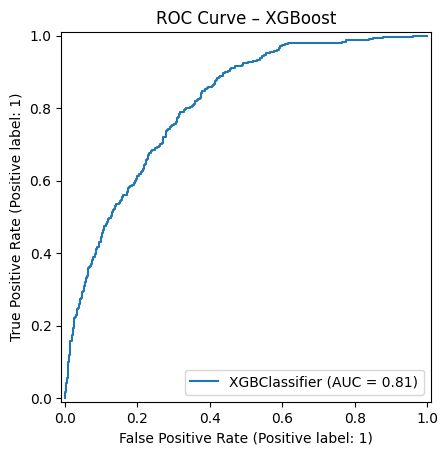

In [13]:
from sklearn.metrics import RocCurveDisplay
#plot ROC Curve
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title("ROC Curve – XGBoost")
plt.show()


### **Step 10: Model Interpretability**

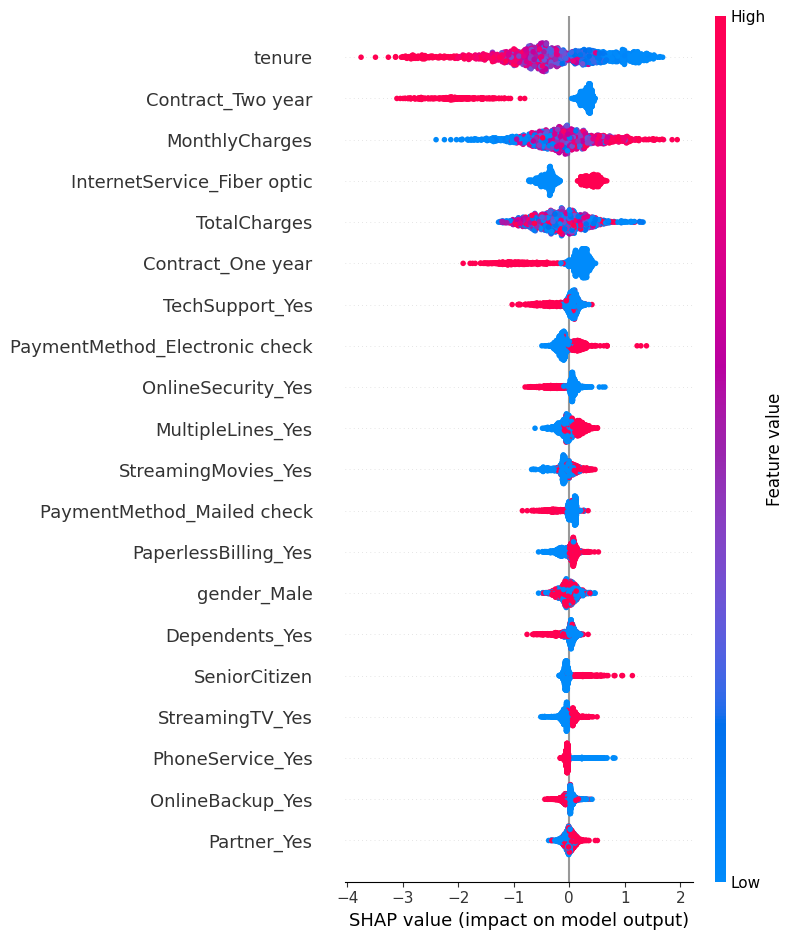

In [19]:
import shap

#creates an explainer object specifically for xgboost model
explain = shap.Explainer(xgb)
shap_values = explain(X_test) #for each customer in test set, calculate how much each feature pushed the prediction

#plot graph
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns)

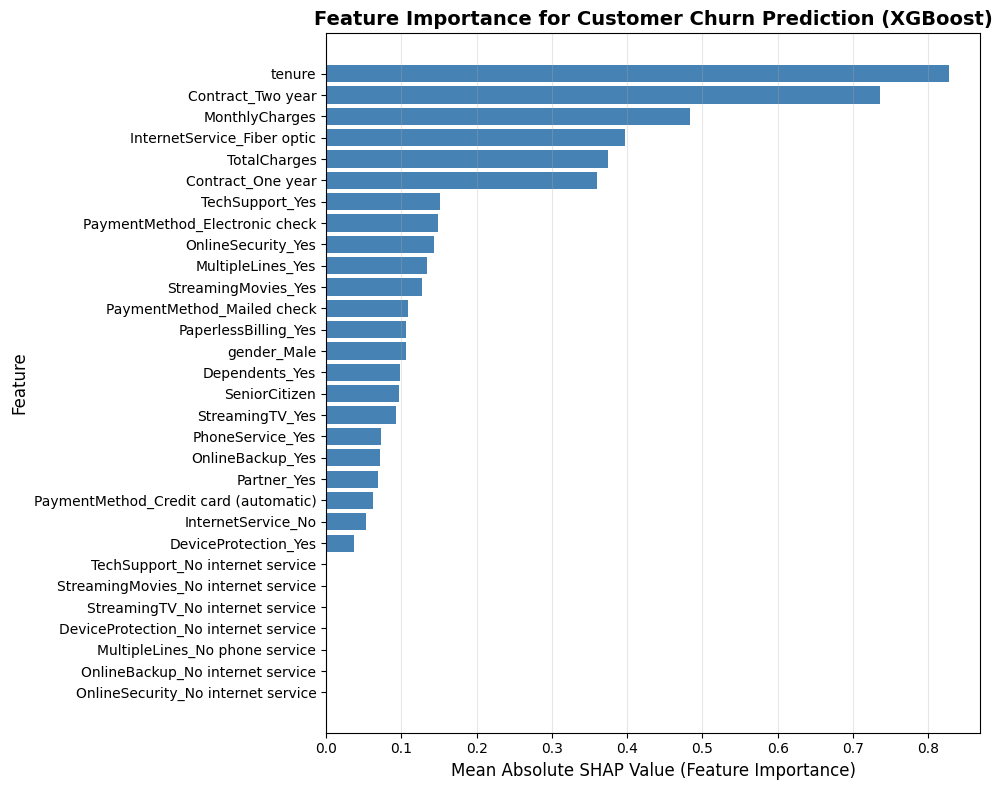

In [22]:
#calculate mean absolute SHAP values for each feature
mean_values = np.abs(shap_values.values).mean(axis=0)

#get feature names
feature_names = X.columns

#create a DataFrame for easier plotting
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_values
}).sort_values('importance', ascending=True)

#create bar chart
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Mean Absolute SHAP Value (Feature Importance)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance for Customer Churn Prediction (XGBoost)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()